In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
from math import cos, sin, pi
from IPython.display import HTML, Video, display
from tqdm import tqdm

"""
-----------------------
Helper Functions: Later move it to another file.py
-----------------------

"""
def selfPropulsionForce(m, tau, desiredSpeed, desiredDirection, velocity):
    speed=((velocity**2).sum(axis=1))**0.5
    angle=np.arctan2(velocity[:,1],velocity[:,0])
    ds_dt=(desiredSpeed-speed)*(m/tau)
    dphi_dt=np.arctan2(np.sin(desiredDirection-angle),np.cos(desiredDirection-angle))/(tau*m)
    outforce=np.zeros_like(velocity)
    outforce[:,0]=ds_dt*np.cos(angle)+dphi_dt*(-speed*np.sin(angle))
    outforce[:,1]=ds_dt*np.sin(angle)+dphi_dt*(speed*np.cos(angle))
    return outforce

def wallForce(position, R, A,  B, Ly,t):
    N = position.shape[0]
    # return np.zeros((N,2))
    y = position[:, 1]
    dist_from_walls=np.zeros((N,2))
    dist_from_walls[:,0]=y
    dist_from_walls[:,1]=Ly-y
    # print(dist_from_walls)
    if dist_from_walls.min()<R:
        print('some agent is too close to the wall')
        print(position[np.where(dist_from_walls==dist_from_walls.min())[0][0]],t)
        raise ValueError('some agent is too close to the wall')
    closest_wall=np.argmin(dist_from_walls,axis=1)
    bottom_force_indices=(closest_wall==0)*(dist_from_walls[:,0]<3*R)
    top_force_indices=(closest_wall==1)*(dist_from_walls[:,1]<3*R)
    force = np.zeros_like(position)
    force[bottom_force_indices,1]=A*np.power(dist_from_walls[bottom_force_indices,0]-R,-B)
    force[top_force_indices,1]=-A*np.power(dist_from_walls[top_force_indices,1]-R,-B)
    return force

def interactionForce(position, R, A, B, Lx, Ly):
    N = position.shape[0]
    epsilon = 0*1e-6 # Used to avoid infinity
    agent_size = 2 * R

    x = position[:, 0].reshape(-1, 1)
    y = position[:, 1].reshape(-1, 1)

    dx = x - x.T
    dy = y - y.T


    dx_u = dx - np.round(dx / Lx) * Lx
    dy_u = dy

    # Euclidean distance calculation
    dist = np.sqrt(dx_u**2 + dy_u**2)
    
    valid_index = (dist < (3*R)) & (dist > 0)

    # Unit vectors
    dij_x = np.zeros_like(dist)
    dij_y = np.zeros_like(dist)
    np.divide(dx_u, dist, out=dij_x, where=dist>epsilon)
    np.divide(dy_u, dist, out=dij_y, where=dist>epsilon)   
    # np.divide(dx_u, dist+epsilon, out=dij_x)#, where=dist>epsilon)
    # np.divide(dy_u, dist+epsilon, out=dij_y)#, where=dist>epsilon)
    
    # Apply valid_index mask
    dij_x[~valid_index] = 0
    dij_y[~valid_index] = 0
    
    # Effective distance
    effective_dist = np.maximum(dist - agent_size, epsilon)
    
    # Force magnitude calculation
    force_magnitude = np.zeros_like(dist)
    np.power(effective_dist, -B, out=force_magnitude, where=effective_dist>epsilon)
    force_magnitude *= -A
    
    force_magnitude[~valid_index] = 0

    interaction_force = np.column_stack((np.sum(force_magnitude * dij_x, axis=0),np.sum(force_magnitude * dij_y, axis=0)))

    return interaction_force


xData = []
yData = []

uData = []
vData = []

"""
--------------------------------
code starts here
--------------------------------
"""
# Current case


for rep in range(10):
    
    Lx=20
    Ly=19
    R = 1

    
    ### Lane formation case ########
    Nr = 1/2
    # density = 0.5
    case = "Lane_Formation"
    title = "Lane Formation"

    
    simArea = Lx*(Ly-6)

    N=40
    
    total_area_occupied = N * np.pi * R**2
    total_simulation_area = Lx*Ly
    
    # number of agent in each group
    g1 = int(round(N * Nr))
    g1=1
    g2 = N - g1
    
    # Initial Position
    position=np.array(sum([[[x,y] for y in [1.5,5.5,9.5,13.5,17.5]] for x in [2,4.5,7,9.5,12,14.5,17,19.5]],[]))#[np.random.permutation(np.arange(N))]
    # position=np.array(sum([[[x,y] for y in [1.25,3.75,6.25,8.75,11.25,13.75,16.25,18.75]] for x in [2,4.5,7,9.5,12,14.5,17,19.5]],[]))[np.random.permutation(np.arange(N))]
    # position=np.array([[3,10],[17,10]])
    # position=np.array([[4.5,9.5]]+sum([[[x,y] for y in [1.5,5.5,9.5,13.5,17.5]] for x in [12,14.5,17,19.5]],[]))
    position=position+(np.random.random(size=position.shape)-0.5)*0.001
    position[:,0]=position[:,0]%Lx
    
    # Initial Speed
    speed = 0
    
    # Initial Direction
    theta = np.random.uniform(0, 2* np.pi, size = (N, 1))
    # theta = np.ones((N, 1))
    # theta[:g1] = 0
    # theta[g1:] = np.pi
    # theta = np.ones(shape=(N,1))*np.pi/2
    # print(theta)
    # Parameter for force calculation
    m = 1
    A = 0.01
    B = 3
    tau = 1
    
    # Inital velocity
    velocity = speed * np.column_stack((np.cos(theta), np.sin(theta)))
    
    # Desired speed
    desiredSpeed = np.ones(N) * 1
    # desiredSpeed = np.random.random(size=(N,1))*2
    # desiredSpeed[:g1] = 0
    
    
    # Desired direction
    desiredDirectionA = np.ones(N)
    desiredDirectionA[:g1] = 0
    desiredDirectionA[g1:] = np.pi

    
    # Desired velocity
    # desiredVelocity = desiredSpeed * desiredDirection
    
    
    # Time parameters
    deltaT = 0.005
    timeStep = 35000
    totalTime = deltaT*timeStep
    
    fig, ax = plt.subplots()
    
    # Circle patches for each group
    circles_g1 = [patches.Circle((position[i, 0], position[i, 1]), radius=R, color='blue',alpha=0.5, label='Group 1' if i == 0 else "") for i in range(g1)]
    circles_g2 = [patches.Circle((position[i, 0], position[i, 1]), radius=R, color='red',alpha=0.5, label='Group 2' if i == g1 else "") for i in range(g1, len(position))]
    for circle in circles_g1 + circles_g2:
        ax.add_patch(circle)
    
    # ax.set_title(f"{title} | Density = {density} | Nr = {round(Nr, 2)}")
    ax.set_xlim([0, Lx])
    ax.set_ylim([0, Ly])
    ax.set_aspect('equal', 'box')
    ax.legend(loc = 'upper left',  bbox_to_anchor=(1, 1), markerscale=0.5)
    plt.savefig(f"InitialMulti_{case}.png")
    
    
    
    xData.append(position[:,0])
    yData.append(position[:,1])
    
    uData.append(velocity[:,0])
    vData.append(velocity[:,1])
    
    
    updateT=tau
    updateF=round(updateT/deltaT)
    desses=[]
    forces=[]
    deltheta=np.pi/8
    numagents=N
    for t in tqdm(range(timeStep)):
      # Force calculation
        f1 = selfPropulsionForce(m, tau, desiredSpeed, desiredDirectionA, velocity)
        f2 = interactionForce(position, R, A, B, Lx,Ly)
        f3 = wallForce(position, R, A, B, Ly,t)
        force = (f1+f2+f3)/m
    
        # newPosition = np.add(position, np.multiply(newVelocity, np.ones((N, 1))*deltaT))
        newPosition = position + (velocity * deltaT) + (0.5 * force * deltaT**2)
        newPosition[:,0] = (newPosition[:,0]) % Lx
    
        # force = 0
        deltaV = force * deltaT
    
        vint = velocity + deltaV
    
        f1_new = selfPropulsionForce(m, tau, desiredSpeed, desiredDirectionA, vint) 
        f2_new =  interactionForce(newPosition, R, A, B, Lx,Ly)
        f3_new = wallForce(newPosition, R, A, B, Ly,t)
        forceNew = (f1_new + f2_new + f3_new)/m
        
        newVelocity = velocity + (0.5 * (force + forceNew)) * deltaT #+ 0.2*(np.random.random(size=velocity.shape)-0.5)*deltaT
    
        velocity = newVelocity
        position = newPosition
        
        # plt.pause(0.001)
        
        # Stroing the data
        xData.append(newPosition[:,0])
        yData.append(newPosition[:,1])
        
        uData.append(newVelocity[:,0])
        vData.append(newVelocity[:,1])
        forces.append([f1,f2,f3])
    # f3s.append(f3)
# plt.show()

# Converting the data structure for later use



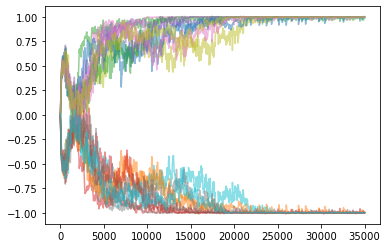

In [3]:
# print(np.array(uData).shape)
for i in range(10):
    k=np.array(uData).reshape((10,35001,40))[i]
    plt.plot(k[:,:g1].mean(axis=1),alpha=0.5)
    plt.plot(k[:,g1:].mean(axis=1),alpha=0.5)

Text(-0.5, 1500, '0.22')

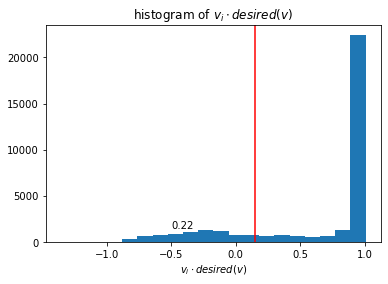

In [11]:
plt.title('histogram of $v_i \\cdot desired(v)$')
plt.xlabel('$v_i \\cdot desired(v)$')
plt.axvline(0.15,color='red')
k=((np.array(uData)*np.cos(desiredDirectionA).reshape(-1,1).T)[:,0]).flatten()
plt.hist(k,20)
frac=1-(k>0.15).sum()/(k<500).sum()
plt.text(-0.5,1500,format(frac,'.2g'))

In [ ]:
print('a')
# filename='./bidisperse/slakdfjkls40agents_withfsm_serial_0.2tau_0.2A'+'_'+str(tau_fut)+'_'+format(updateT,'.2g')+'_maxdel2'
# xData = np.array(xData).T
# yData = np.array(yData).T
# filename='./bidisperse/kljnew40agents_withfsm_serial_0.2tau_0.2A'+'_'+str(tau_fut)+'_'+format(updateT,'.2g')+'_maxdel2'
# filename='./bidisperse/2agents_temp_lessmove_parallel_arrows'
filename='./bidisperse/nematic'
for i in range(0,timeStep,125):
    plt.figure()
    for ag in range(xData.shape[0]):
        xpos=(xData[ag,i])
        ypos=(yData[ag,i])
        vx=uData[i][ag]
        vy=vData[i][ag]
        # desx=desdirs[i][ag,0]
        # desy=desdirs[i][ag,1]
        # dir=cmath.rect(1,dirdata[t,ag])
        plt.gca().add_patch(plt.Circle((xpos,ypos),1,fc='red' if ag<g1 else 'blue'))
        plt.arrow(xpos,ypos,vx,vy)
        # plt.arrow(xpos,ypos,desx,desy,color='white',alpha=0.5)
        # plt.arrow(xpos,ypos,np.real(dir),np.imag(dir))
    plt.xlim(-1,Lx+1)
    plt.ylim(-1,Ly+1)
    plt.axhline(0)
    plt.axhline(Ly)
    plt.gca().set_aspect(1)
    plt.savefig(filename+'_prop_'+str(i)+'.png',facecolor='white')
    plt.close()